# Some dynamical systems approaches
(c) 2017 Justin Bois. This work is licensed under a Creative Commons Attribution License CC-BY 4.0. All code contained herein is licensed under an MIT license.

http://be150.caltech.edu/2017/handouts/dynamical_systems_approaches.html

http://www.cds.caltech.edu/~murray/BFSwiki/index.php/Main_Page

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', context='notebook', palette=colors, 
        rc={'axes.labelsize': 16})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

As an example, we can plot a trajectory of a toggle, shown below.

Toggle

The dimensionless dynamical equations are

$$\dot a = \frac{\beta}{ 1 + b^n} − a$$

$$\gamma^{-1}\dot b = \frac{\beta}{ 1 + a^n}− b$$

where we have assumed for simplicity that the production rates of A and B are the same, as are the Hill coefficients for repression. We can code up the expression for the right-hand-side of the toggle dynamics and solve numerically as we have done all term.

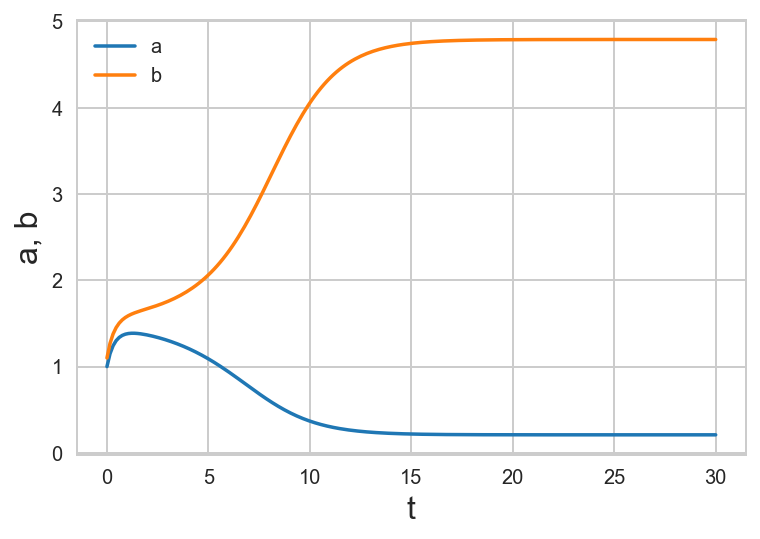

In [2]:
def toggle(ab, t, beta, gamma, n):
    """Right hand side for toggle ODEs."""
    a, b = ab
    return np.array([beta / (1 + b**n) - a,
                     gamma * (beta / (1 + a**n) - b)])

# Parameters
gamma = 1
beta = 5
n = 2
args = (beta, gamma, n)

# Initial condition
ab0 = np.array([1, 1.1])

# Solve
t = np.linspace(0, 30, 200)
ab = scipy.integrate.odeint(toggle, ab0, t, args=args)

# Plot
plt.plot(t, ab)
plt.xlabel('t')
plt.ylabel('a, b')
plt.legend(('a', 'b'));

This is the way we have been looking at the dynamics for most of the term, but we could also plot the result in the a-b plane, which is the phase plane.

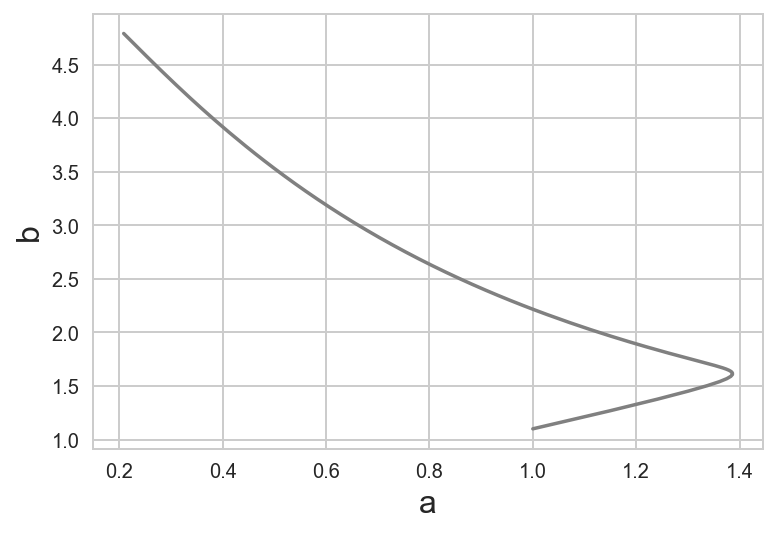

In [3]:
# Plot
plt.plot(ab[:,0], ab[:,1], color='gray')
plt.xlabel('a')
plt.ylabel('b');

# Many trajectories and streamplots

We can generate lots and lots of trajectories to see how the system evolves. We can do this by solving for the dynamics for different initial conditions.

For convenience, we will great an Axis object and update the plot as we go along.

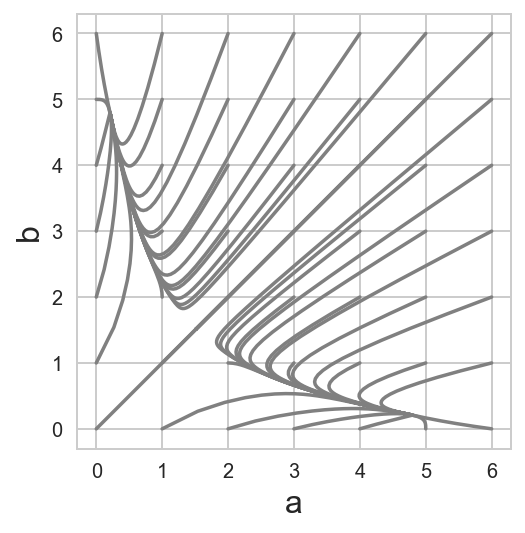

In [4]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

for a0 in range(7):
    for b0 in range(7):
        ab = scipy.integrate.odeint(toggle, np.array([a0, b0]), t, args=args)
        ax.plot(*ab.transpose(), color='gray');

This is interesting, but kind of difficult to interpret. First, we would like to see arrowheads to know what direction the system is moving in. Furthermore, we would like to see some cleaner line spacing. Finally, it would be useful to know how fast the system is moving as it traverses parameter space. Fortunately, Matplotlib has a built-in function, `plt.streamplot()` to construct these plots. Under the hood, it integrates the dynamical equations numerically, taking care of how dense the lines are. It does not plot full lines, but stops lines when the density gets too great to maintain clarity. It also allows for variable line thickness.

The arguments to `plt.streamplot()` is a grid of derivative values, which it uses to make interpolants for the streamlines. I wrote a wrapper around this function to allow input of the right-hand-side of the dynamical systems as we have been using them with `scipy.integrate.odeint()`.

In [5]:
def plot_flow_field(ax, f, u_range, v_range, args=(), n_grid=100):
    """
    Plots the flow field with line thickness proportional to speed.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    u_range : array_like, shape (2,)
        Range of values for u-axis.
    v_range : array_like, shape (2,)
        Range of values for v-axis.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    # Set up u,v space
    u = np.linspace(u_range[0], u_range[1], n_grid)
    v = np.linspace(v_range[0], v_range[1], n_grid)
    uu, vv = np.meshgrid(u, v)

    # Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = f(np.array([uu[i,j], vv[i,j]]), None, *args)

    # Compute speed
    speed = np.sqrt(u_vel**2 + v_vel**2)

    # Make linewidths proportional to speed,
    # with minimal line width of 0.5 and max of 3
    lw = 0.5 + 2.5 * speed / speed.max()

    # Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel, linewidth=lw, arrowsize=1.2, 
                  density=1, color='thistle')

    return ax

With this function, we can now generate our nice phase portrait.

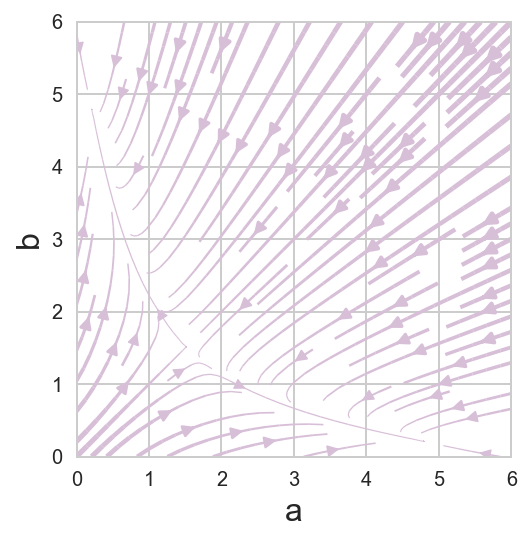

In [8]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

ax = plot_flow_field(ax, toggle, (0, 6), (0, 6), args=args)

This is nice! We see that the system moves rapidly toward the point $a \approx b \approx 1.5$ and then diverges toward either high b and low a or vice versa.

There is an important caveat to this method, though. The way we have constructed this assumes that the right hand side of the dynamics have no explicit t-dependence. So, this will not work for delay oscillators or systems with parameters that vary with time. For those, you will have to generate lots of trajectories.

# Nullclines

Now, this is not the only thing we have plotted in the phase plane this term. We also plotted the nullclines in the phase plane. We did this very early on in the course. Remember that the nullclines are the lines defined respectively be $\dot a=0$ and $\dot b=0$, and the places where they cross are fixed points (steady states). In the case of the toggle, the nullclines are

$$a = \frac{\beta}{ 1 + b^n}$$

$$b = \frac{\beta}{ 1 + a^n}$$

Let's plot the nullclines. We'll write a function to do this.

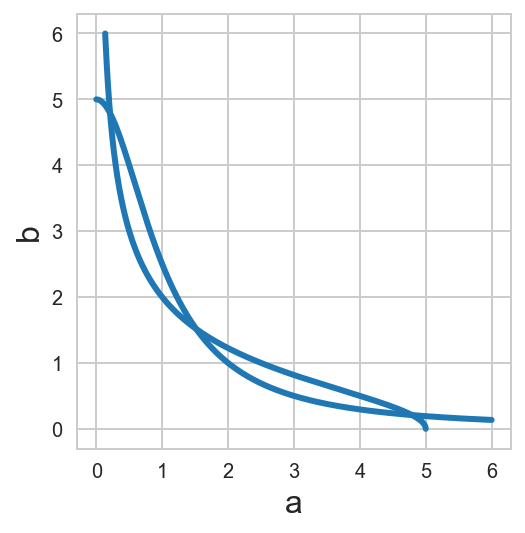

In [9]:
def plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n, 
                            colors=['#1f77b4', '#1f77b4'], lw=3):
    """Add nullclines to ax."""
    # a-nullcline
    nca_b = np.linspace(b_range[0], b_range[1], 200)
    nca_a = beta / (1 + nca_b**n)

    # b-nullcline
    ncb_a = np.linspace(a_range[0], a_range[1], 200)
    ncb_b = beta / (1 + ncb_a**n)

    # Plot
    ax.plot(nca_a, nca_b, lw=lw, color=colors[0])
    ax.plot(ncb_a, ncb_b, lw=lw, color=colors[1])
    
    return ax
    
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')
ax = plot_null_clines_toggle(ax, [0, 6], [0, 6], beta, gamma, n)

# Fixed points

We have seen plots like this before, and we have annotated them with fixed points. Let's go ahead and do that.

In general to compute fixed points, you typically have to resort to numerical methods. It is also sometimes hard to derive how many fixed points a given system will have. Upon finding the fixed points, you may again have to do linear stability analysis to determine if they are stable or not. So, fixed point determination is often done on a case-by-case basis (though there are packages that attempt to automatically find fixed points).

We have already worked in out in class that the toggle has either one or three fixed points. In the case of three fixed points, the middle one (that in which a and b take on the intermediate values among those of the fixed points) is unstable.

Fortunately, for the toggle with the symmetry we have built-in, we know that for the unstable fixed point, $a=b$, specifically with

$$a = \frac{\beta}{1 + a^n}.$$

For integer $n$, this is a polynomial equation that we can solve. For the other two fixed points, by symmetry we also have that $a_1,b_1=b_3,a_3$, where the 1 subscript denotes a fixed point with $a$ high and $b$ low and the subscript 3 denotes $a$ fixed point with $b$ high and a low. One of these fixed points satisfies

$$b = \beta(1 + (\frac{\beta}{1 + b^n})^n)^{-1}$$

We can use `scipy.optimize.fixed_point()` to find this fixed point. (Note that the function `scipy.optimize.fixed_point()` is, confusingly, using the term fixed point to mean the fixed point $x_0$ of a function $f(x)$ such that $f(x_0)=x_0$.) So, let's write a function to generate the three fixed points.

In [10]:
def fp_toggle(beta, gamma, n):
    """Return fixed points of toggle."""
    # Find unstable fixed point
    coeffs = np.zeros(n+2)
    coeffs[0] = 1
    coeffs[-2] = 1
    coeffs[-1] = -beta
    r = np.roots(coeffs)
    ind = np.where(np.logical_and(np.isreal(r), r.real >= 0))
    fp1 = np.array([r[ind][0].real]*2)

    # Return single fixed point is only one
    if n < 2 or beta <= n/(n-1)**(1+1/n):
        return (fp1,)
    
    # Compute other fixed points
    def fp_fun(ab):
        a, b = ab
        return np.array([beta / (1 + b**n), beta / (1 + a**n)])
    fp0 = scipy.optimize.fixed_point(fp_fun, [0, 1])
    fp2 = fp0[::-1]
    
    return (fp0, fp1, fp2)

Now that we have this function, we can add them to the plot. Let's write a function to do this as well.

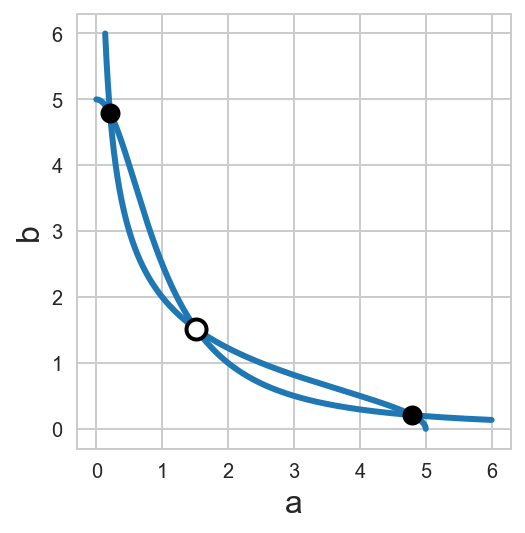

In [12]:
def plot_fixed_points_toggle(ax, beta, gamma, n):
    """Add fixed points to plot."""
    # Compute fixed points
    fps = fp_toggle(beta, gamma, n)
    
    # Plot
    if len(fps) == 1:
        ax.plot(*fps[0], '.', color='black', markersize=20)
    else:
        ax.plot(*fps[0], '.', color='black', markersize=20)
        ax.plot(*fps[1], '.', markerfacecolor='white', markeredgecolor='black', 
                markeredgewidth=2, markersize=20)
        ax.plot(*fps[2], '.', color='black', markersize=20)

    return ax
ax = plot_fixed_points_toggle(ax, beta, gamma, n)
fig

# Putting it together: streamlines with nullclines and fixed points¶
We can now plot everything together using the plotting functions we've developed.


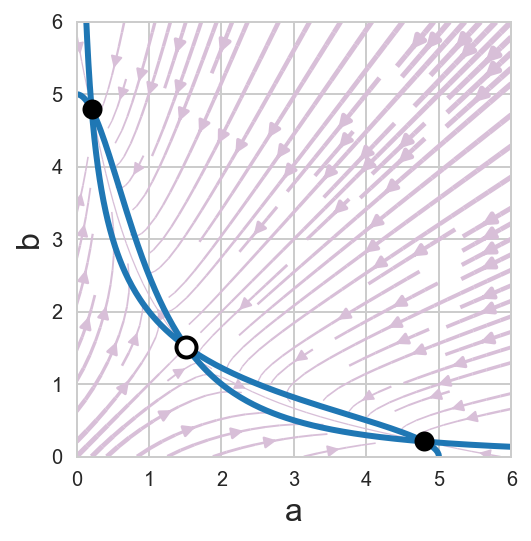

In [14]:
# Set up the figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

# Build the plot
a_range = [0, 6]
b_range = [0, 6]
ax = plot_flow_field(ax, toggle, a_range, b_range, args=args)
ax = plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_fixed_points_toggle(ax, beta, gamma, n)

Now the dynamics become clear. The system rushes toward the **saddle** (the unstable fixed point that has one positive and one negative eigenvalue in the linearization of the dynamical system) and then goes toward one of the two stable fixed points.

It might be nice to also plot some sample trajectories on the phase plot. Here's a generic function to do that.

In [15]:
def plot_traj(ax, f, y0, t, args=(), color='black', lw=2):
    """
    Plots a trajectory on a phase portrait.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    y0 : array_like, shape (2,)
        Initial condition.
    t : array_like
        Time points for trajectory.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    y = scipy.integrate.odeint(f, y0, t, args=args)
    ax.plot(*y.transpose(), color=color, lw=lw)
    return ax

Let's add a few trajectories.

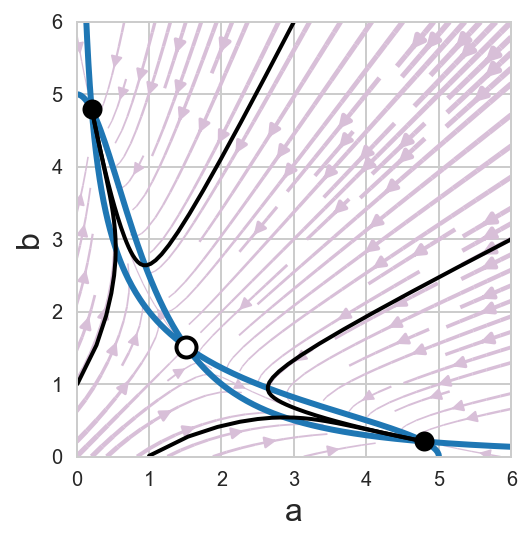

In [16]:
ax = plot_traj(ax, toggle, np.array([0.01, 1]), t, args=args)
ax = plot_traj(ax, toggle, np.array([1, 0.01]), t, args=args)
ax = plot_traj(ax, toggle, np.array([3, 6]), t, args=args)
ax = plot_traj(ax, toggle, np.array([6, 3]), t, args=args)
fig

# The separatrix

There is one other feature we might want to consider here. Note that any trajectories that start above the diagonal end up going toward the node with $b$ high and $a$ low, and those that start below the diagonal end up going toward the node with $a$ high and $b$ low. The diagonal is special in this way. It is called the **separatrix**, indicating that it separates two behaviors of the system. We might also like to plot the separatrix on the plot. In this case, it is a straight line, but this is not always the case. We will adjust $\gamma$ to be greater than 1, therefore breaking the symmetry and making the separatrix calculation nontrivial.

For computing the separatrix, we start at the saddle and then integrate the system backwards in time, starting just off of the saddle point.

In [17]:
def plot_separatrix_toggle(ax, a_range, b_range, beta, gamma, n, t_max=30, eps=1e-6, 
                           color='tomato', lw=3):
    """
    Plot separatrix on phase portrait.
    """
    # Compute fixed points
    fps = fp_toggle(beta, gamma, n)
    
    # If only one fixed point, no separatrix
    if len(fps) == 1:
        return ax
    
    # Negative time function to integrate to compute separatrix
    def rhs(ab, t):
        # Unpack variables
        a, b = ab
    
        # Stop integrating if we get the edge of where we want to integrate
        if a_range[0] < a < a_range[1] and b_range[0] < b < b_range[1]:
            return -toggle(ab, t, beta, gamma, n)
        else:
            return np.array([0, 0])

    # Parameters for building separatrix
    t = np.linspace(0, t_max, 400)

    # Build upper right branch of separatrix
    ab0 = fps[1] + eps
    ab_upper = scipy.integrate.odeint(rhs, ab0, t)

    # Build lower left branch of separatrix
    ab0 = fps[1] - eps
    ab_lower = scipy.integrate.odeint(rhs, ab0, t)

    # Concatenate, reversing lower so points are sequential
    sep_a = np.concatenate((ab_lower[::-1,0], ab_upper[:,0]))
    sep_b = np.concatenate((ab_lower[::-1,1], ab_upper[:,1]))
    
    # Plot
    ax.plot(sep_a, sep_b, '-', color=color, lw=lw)
    
    return ax

Now, let's put a phase portrait together with $\gamma=2$.

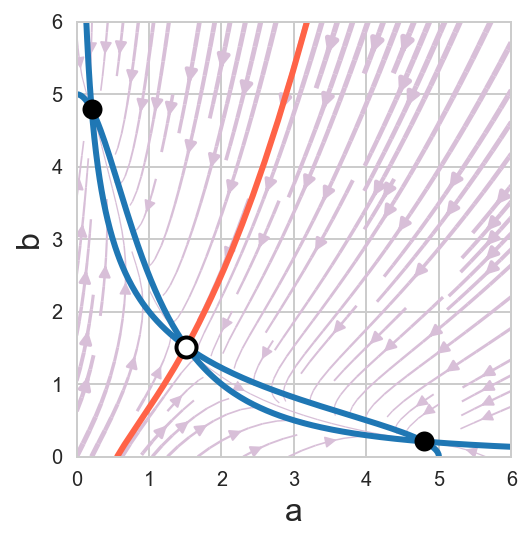

In [18]:
# Parameters
gamma = 2
beta = 5
n = 2
args = (beta, gamma, n)

# Set up the figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

# Build the plot
a_range = [0, 6]
b_range = [0, 6]
ax = plot_flow_field(ax, toggle, a_range, b_range, args=args)
ax = plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_separatrix_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_fixed_points_toggle(ax, beta, gamma, n)

This gives a pretty complete picture of how this dynamical system behaves for this parameter set. We can see the nullclines, the fixed points, the separatrix, and how the system evolves. Quite informative!

# Identification of oscillations
We briefly mentioned that there are some general ways to identify dynamical systems that can undergo oscillations. We will now discuss a couple very power theorems for two-dimensional systems. We state both without proof.

### Bendixson's criterion

This theorem makes it possible to rule out sustained oscillations (defined as orbits, closed curves on which trajectories remain after entering).

Consider a dynamical system

$$\dot x = f(x,y)$$
$$\dot y = g(x,y).$$

In a simply connected region $D$ of the $x-y$ plane, if the quantity

$$\frac{\partial f}{\partial x} + \frac{\partial g}{\partial y}$$

is nonzero and does not change sign on D, then the dynamical system has no orbits entirely D.

### Poincaré-Bendixson Theorem
We will not state the full theorem here, which involves $\omega$ limit sets, but will instead state important consequences.

If a two-dimensional dynamical system has no fixed points, it has a periodic solution.
If a two-dimensional dynamical system has only one unstable fixed point that is not a saddle, it has a periodic solution.
This is useful to decide for what parameter values a system that can potentially oscillate may actually do so. We will not use it directly in this tutorial, but it is useful to know.